In [8]:
import utils
from dataset import BuildingDataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from model import get_transform
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torch

In [2]:
# Load data for exploration.
dataset_test = BuildingDataset(
    "datasets/mlc_training_data/images_annotated/",
)
dataset_test[0][1]

{'boxes': BoundingBoxes([[451., 332., 484., 357.],
                [305., 464., 365., 503.],
                [480., 387., 511., 410.],
                [448., 368., 474., 400.],
                [418., 293., 452., 388.],
                [457., 283., 511., 338.],
                [330., 362., 419., 481.],
                [492., 350., 511., 371.],
                [401., 402., 433., 435.],
                [349., 276., 422., 336.]], format=BoundingBoxFormat.XYXY, canvas_size=[512, 512]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'masks': Mask([[[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]],
 
       [[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]],
 
       [[0, 0,

In [3]:
# Load data for exploration.
dataset_expl = BuildingDataset(
    "datasets/mlc_training_data/images_annotated/",
)

# data = [dataset_expl[i] for i in range(10)]
data = [d for d in dataset_expl]

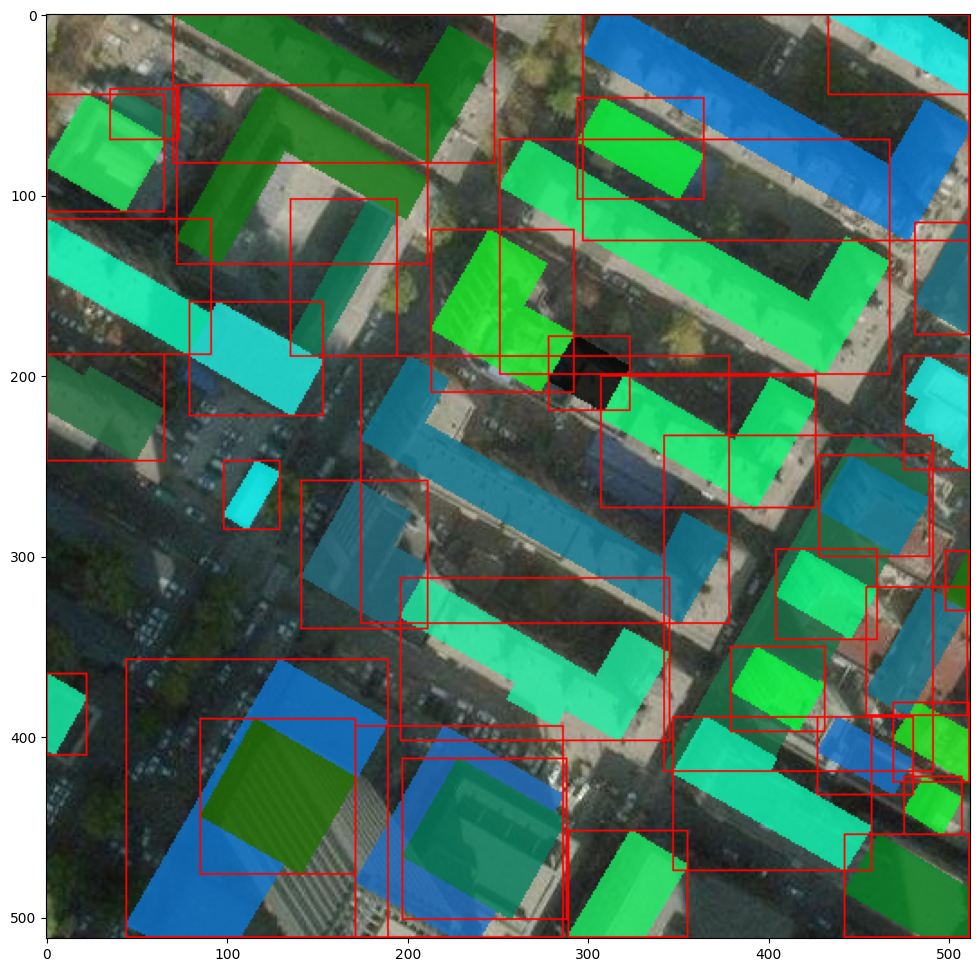

In [9]:
img, masks, boxes = data[2][0], data[2][1]["masks"], data[2][1]["boxes"]


def show_segmentation(img, masks, boxes=None, bcolors="red"):
    output_image = draw_segmentation_masks(img, masks.to(torch.bool), alpha=0.8)
    if boxes is not None:
        output_image = draw_bounding_boxes(output_image, boxes, colors=bcolors)
    plt.figure(figsize=(12, 12))
    plt.imshow(output_image.permute(1, 2, 0))


show_segmentation(img, masks, boxes)

Quantile 0.25: 6.0
Quantile 0.5: 9.0
Quantile 0.75: 18.0
Quantile 0.95: 54.0
Quantile 0.99: 99.0


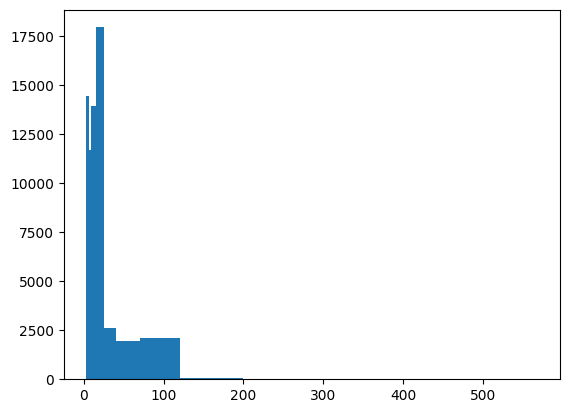

In [10]:
heights = [d[1]["building_heights"] for d in data]
heights = torch.cat(heights).numpy()

counts, bins = np.histogram(
    heights, bins=[3, 6, 9, 15, 25, 40, 70, 120, 200, heights.max()]
)
plt.stairs(counts, bins, fill=True)

for q in [0.25, 0.5, 0.75, 0.95, 0.99]:
    print(f"Quantile {q}: {np.quantile(heights, q)}")

In [12]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

dataset = BuildingDataset(
    "datasets/mlc_training_data/images_annotated/",
    transforms=get_transform(train=True),
)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

# For Training
images, targets = next(iter(data_loader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])

{'loss_classifier': tensor(2.4109, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.6867, grad_fn=<DivBackward0>), 'loss_mask': tensor(0.6807, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(2.1570, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1585, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>), 'masks': tensor([], size=(0, 1, 300, 400))}


In [ ]:
from model import train

train()